In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

In [11]:
def load_iops(filename):
    iops = 0
    
    with open(filename, 'rt') as f:
        # Skip the warning that fio prints into the JSON output
        assert f.readline().strip() == 'fio: clocksource=cpu may not be reliable'
        
        data = json.load(f)
        for job in data['jobs']:
            iops += job['read']['iops'] + job['write']['iops']
    
    return iops

def load_data():
    '''Returns iops dict[iodepth][series]'''
    data = {}
    
    for series in os.listdir('results'):
        dirname = os.path.join('results', series, 'iodepth')
        
        for iodepth in os.listdir(dirname):
            filename = os.path.join(dirname, iodepth, 'fio-output.json')
            iops = load_iops(filename)
            data.setdefault(iodepth, {})[series] = iops
        
    return data

In [31]:
def plot(data):
    iodepths = [str(x) for x in sorted(int(x) for x in data)]
    results = [data[x] for x in iodepths]
    series = ['with-blk_io_plug', 'no-blk_io_plug', 'call-after-dispatch', 'blk_io_plug-thread-local', 'v7.2.0'] # sorted(results[0])
    
    values = {}
    for s in series:
        values[s] = [x[s] for x in results]
    
    x = np.arange(len(iodepths))
    width = 0.85 / len(series)
    
    _, ax = plt.subplots()
    x_offset = -0.5
    for series in values:
        ax.bar(x + x_offset, values[series], width, label=series)
        x_offset += width
    ax.legend(loc='upper left')
    ax.set_xticks(x)
    ax.set_xticklabels(iodepths)

    plt.xlabel('iodepth')
    plt.ylabel('iops')
    plt.show()

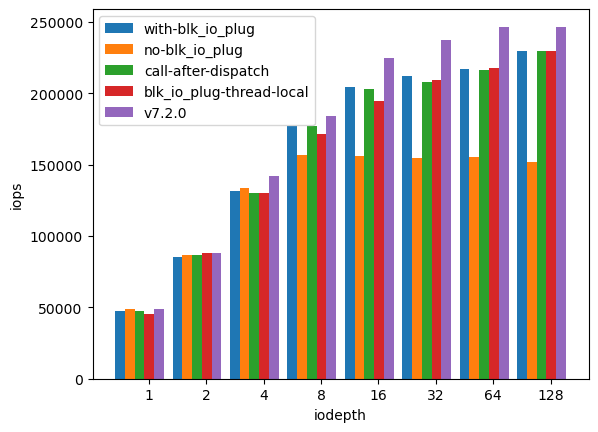

In [34]:
data = load_data()
plot(data)

In [35]:
for iodepth in [str(x) for x in sorted(int(x) for x in data)]:
    a = data[iodepth]['with-blk_io_plug']
    for series in data[iodepth]:
        if series in ['with-blk_io_plug', 'no-blk_io_plug', 'v7.2.0', 'call-after-dispatch']:
            continue
        b = data[iodepth][series]
        print(f'{iodepth:4} {int(b):6} {int(b * 100.0 / a - 100):+}%')

1     45612 -4%
2     87967 +2%
4    129872 +0%
8    171096 -3%
16   194508 -4%
32   208947 -1%
64   217647 +0%
128  229629 +0%
